# **The detection of outliers (Valores Atípicos)** 

## **Univariate Apoach**

In [ ]:
import numpy as np
from sklearn.datasets import load_boston
boston = load_boston()

# the variable CHAS, which is indexed 3, is  binary
continuous_variables = [n for n in range(np.shape(boston.data)[1]) if n != 3]


Deteccion de valores atípicos usando la notacion Z, que son los valores que estan fuera de 3 desviaciones Standar. Producto de que **la Regla Empírica** establece que *el 99.7% de los datos se encuentra dentro de 3 desviaciones Standar*; *el 95% de os datos dentro de 2 Deviaciones* y *el 68% aproximadamente dentro de 1 Desviación Standar* 

In [2]:
from sklearn import preprocessing

normalized_data = preprocessing.StandardScaler().fit_transform(
    boston.data[:, continuous_variables])

outliers_rows, outliers_columns = np.where(np.abs(normalized_data) > 3)

list(zip(outliers_rows, outliers_columns))[:8]


[(55, 1), (56, 1), (57, 1), (102, 10), (141, 11), (199, 1), (200, 1), (201, 1)]

## **Multivariate Apoach**


### **EllipticEnvelope**
Deteccion de valores atipicos **multivariantes** mediante **EllipticEnvelope** que comprueba la distancia de cada observacion con respecto a la media general que tiene en cuenta todas las variables del conjunto. Hay que pasarle un *argumento de contaminacion* que por defecto es de 0.1 pero que es muy alto de acuerdo ala regla empirica por lo que se recomienda 0.01 o 0.02.

In [3]:
# Create an artificial distribution made of blobs

from sklearn.datasets import make_blobs
blobs = 2
blob = make_blobs(n_samples=100, n_features=2, centers=blobs,
                  cluster_std=1.5, shuffle=True, random_state=5)


**make_blobs** y **make_classification** crean conjuntos de datos multiclase asignando a cada clase uno o más grupos de puntos normalmente distribuidos. **make_blobs** proporciona un mayor control con respecto a los centros y las desviaciones estándar de cada grupo, y se utiliza para demostrar la agrupación. **make_classificationse** especializa en introducir ruido a través de: características correlacionadas, redundantes y no informativas

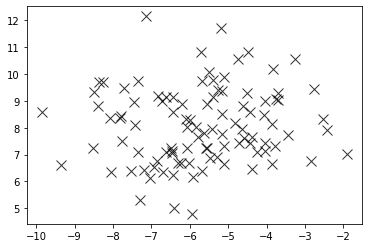

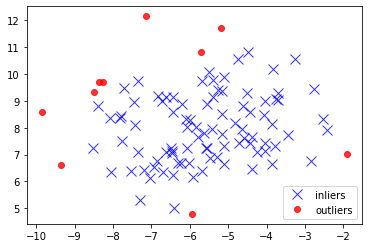

In [4]:
# Robust Covariance Estimate
import matplotlib.pyplot as plt
from sklearn.covariance import EllipticEnvelope

robust_covariance_est = EllipticEnvelope(contamination=.1).fit(blob[0])

detection = robust_covariance_est.predict(blob[0])
outliers = np.where(detection == -1)
inliers = np.where(detection == 1)

# Just the distribution
plt.plot(blob[0][:, 0], blob[0][:, 1], 'x', markersize=10,
         color='black', alpha=0.8)
plt.show()


# The distribution and the outliers
a = plt.plot(blob[0][inliers, 0], blob[0][inliers, 1], 'x',
             markersize=10, color='blue', alpha=0.8, label='inliers')
b = plt.plot(blob[0][outliers, 0], blob[0][outliers, 1], 'o',
             markersize=6, color='red', alpha=0.8, label='outliers')

plt.legend((a[0], b[0]), ('inliers', 'outliers'), numpoints=1, loc='lower right')
plt.show()


Cuando hay varias distribuciones en los datos, como si hubiera dos o más conglomerados naturales, el algoritmo trata de ajustarse a una única distribución general y tiende a localizar los posibles valores atípicos sólo en el clúster más alejado, ignorando así otras áreas de los datos que podrían estar potencialmente afectadas por los casos atípicos.
Esta situación no es inusual en los datos reales, y representa una importante **limitación del algoritmo EllipticEnvelope**.

> volvamos l conjunto de datos de ala vivienda en Boston

In [5]:
from sklearn.decomposition import PCA
from sklearn import preprocessing

# Normalized data relative to continuous variables
continuous_variables = [n for n in range(np.shape(boston.data)[1]) if n != 3]
normalized_data = preprocessing.StandardScaler().fit_transform(
    boston.data[:, continuous_variables])

# Just for visualization purposes pick the first 2 PCA components
pca = PCA(n_components=2)
Zscore_components = pca.fit_transform(normalized_data)
vtot = 'PCA Variance explained ' + str(round(np.sum(pca.explained_variance_ratio_), 3))
v1 = str(round(pca.explained_variance_ratio_[0], 3))
v2 = str(round(pca.explained_variance_ratio_[1], 3))
vtot


'PCA Variance explained 0.622'

Se genera una reduccion a dos componentes solo para poder visualizarlo posteriormente.

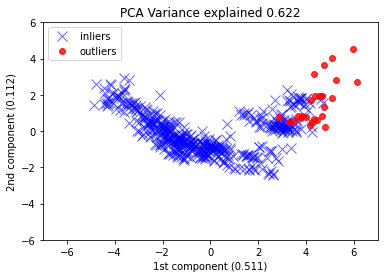

In [6]:
# Robust Covariance Estimate
from matplotlib import pyplot as plt

robust_covariance_est = EllipticEnvelope(store_precision=False,
                                         assume_centered=False, contamination=.05)
robust_covariance_est.fit(normalized_data)
detection = robust_covariance_est.predict(normalized_data)
outliers = np.where(detection == -1)
regular = np.where(detection == 1)

# Draw the distribution and the detected outliers
a = plt.plot(Zscore_components[regular, 0], Zscore_components[regular, 1],
             'x', markersize=10, color='blue', alpha=0.6, label='inliers')
b = plt.plot(Zscore_components[outliers, 0], Zscore_components[outliers, 1],
             'o', markersize=6, color='red', alpha=0.8, label='outliers')
plt.xlabel('1st component ('+v1+')')
plt.ylabel('2nd component ('+v2+')')
plt.xlim([-7, 7])
plt.ylim([-6, 6])
plt.legend((a[0], b[0]), ('inliers', 'outliers'), numpoints=1, loc='best')
plt.title(vtot)
plt.show()


### **OneClassSVM**
OneClassSVM es un algoritmo de aprendizaje automático que aprende cuál
debe ser la distribución de las características a partir de los propios datos,
y por lo tanto es aplicable en una gran variedad de situaciones cuando se
quiere ser capaz de captar todos los valores atípicos pero también los
ejemplos de datos inusuales

Para que **OneClassSVM** funcione como detector de valores atípicos, es
necesario trabajar en sus parámetros principales; se requiere definir el
kernel, el grado, la gamma y el nu:
*   **Núcleo y grado**: Están interconectados. Normalmente, los valores que sugerimos en base a nuestra experiencia son los predeterminados; el tipo de kernel debe ser rbf y su grado debe ser 3. Tales parámetros informarán a OneClassSVM para crear una serie de burbujas de clasificación que abarcan tres dimensiones, permitiéndole modelar incluso las más complejas formas de distribución multidimensional

* **Gamma**: Este es un parámetro que está conectado al kernel RBF. Le sugerimos que lo mantenga lo más bajo posible. Una buena regla general debería ser asignarle un valor mínimo que se encuentre entre el inverso del número de casos y las variables. Por ahora bastará con decir que los valores más altos de gamma tienden a llevar al algoritmo a seguir los datos,
pero más a definir la forma de las burbujas de clasificación.

* **Nu**: Este parámetro determina si tenemos que ajustar la distribución
exacta o si tratamos de obtener un cierto grado de generalización no
adaptándose demasiado a los ejemplos de datos presentes (una
elección necesaria si hay valores atípicos). Se puede determinar
fácilmente con la ayuda de la siguiente fórmula: `nu_estimación = 0,95 * fracción de valores_atípicos + 0,05`
Si el valor de la fracción de valores atípicos es muy pequeño, nu será
pequeño y el algoritmo SVM intentará ajustarse al contorno de los
puntos de datos. Por otro lado, si la fracción es alta, también lo será
el parámetro, lo que obligará a suavizar el límite de las
distribuciones de los inliers.

> probemos el rendimiento de este algoritmo en los datos de las viviendas  en Boston

In [7]:
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn import svm
# Normalized data relative to continuos variables
continuous_variables = [n for n in range(boston.data.shape[1]) if n != 3]
scaler = preprocessing.StandardScaler()
normalized_data = scaler.fit_transform(boston.data[:, continuous_variables])

# Just for visualization purposes pick the first 5 PCA components
pca = PCA(n_components=5)
Zscore_components = pca.fit_transform(normalized_data)
vtot = 'PCA Variance explained ' + str(round(np.sum(pca.explained_variance_ratio_), 3))

# OneClassSVM fitting and estimates
outliers_fraction = 0.02
nu_estimate = 0.95 * outliers_fraction + 0.05
machine_learning = svm.OneClassSVM(
    kernel="rbf", gamma=1.0 / len(normalized_data),
    degree=3, nu=nu_estimate)
    
machine_learning.fit(normalized_data)
detection = machine_learning.predict(normalized_data)
outliers = np.where(detection == -1)
regular = np.where(detection == 1)


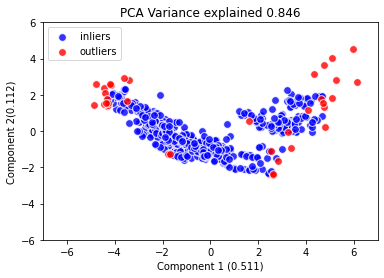

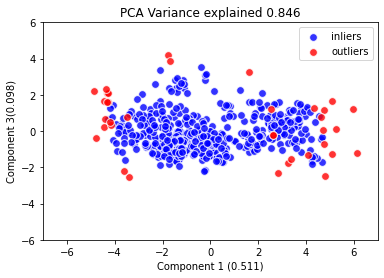

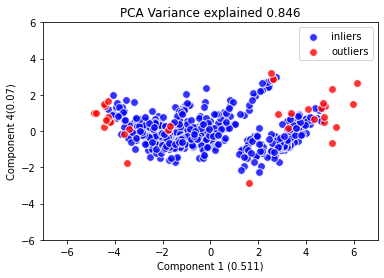

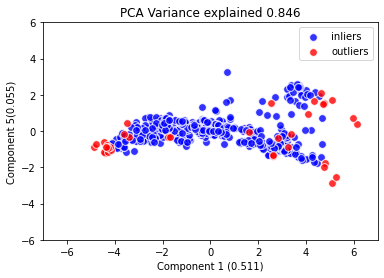

In [8]:
# We will now proceed to visualize the results:
from matplotlib import pyplot as plt

# Draw the distribution and the detected outliers
for r in range(1, 5):
    in_points = plt.scatter(Zscore_components[regular, 0],   Zscore_components[regular, r],
                            c='blue', alpha=0.8, s=60, marker='o', edgecolors='white')

    out_points = plt.scatter(Zscore_components[outliers, 0], Zscore_components[outliers, r],
                             c='red', alpha=0.8, s=60, marker='o', edgecolors='white')

    plt.legend((in_points, out_points), ('inliers', 'outliers'), scatterpoints=1, loc='best')
    plt.xlabel('Component 1 (' + str(round(pca.explained_variance_ratio_[0], 3))+')')
    plt.ylabel('Component '+str(r+1)+'('+str(round(pca.explained_variance_ratio_[r], 3))+')')
    
    plt.xlim([-7, 7])
    plt.ylim([-6, 6])
    plt.title(vtot)
    plt.show()
